# Reducing ill conditioned Markov Chains with Graph Transformation (GT)

This cell loads our `PyGT` package, `tqdm` for progress bars, and defines some helper functions

In [1]:
!pip install PyGT tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as spla
import os.path as Path
from PyGT.io import load_ktn
from PyGT.GT import blockGT
from PyGT.mfpt import full_MFPT_matrix
from PyGT.stats import compute_passage_stats as fpt
from scipy.sparse import diags,eye,issparse
from tqdm.notebook import tqdm
def ev(Q):
    nu = spla.eigvals(Q)
    return np.sort(-nu.real)

def select_states_to_remove(B_matrix,participation):
    N_states = B_matrix.shape[0]
    denseB = np.zeros(B.shape)
    B.todense(out=denseB)

    connections = denseB>0

    rm_vec = np.ones(N_states,bool)

    for i in range(N):
        # boundary nodes
        if not (participation[connections[i]]==participation[i]).min():
            rm_vec[i] = False

        # local minima
        if (u)[participation == participation[i]].min()==(u)[i]:
            rm_vec[i] = False
    print(f"""
        Retained Nodes: {N_states-rm_vec.sum()}
    """)
    return rm_vec

def condition_number_estimation(Q):
    if issparse(Q):
        MQ = Q.todense().copy()
    else:
        MQ = Q.copy()
    MQ -= np.diag(np.diag(MQ))
    return np.linalg.cond(MQ)




## Load 9-macrostate model and BACE-defined community participation

In [2]:
data_path = 'example-data-9-communities/'

T = 5e0

B, K, tau, N, u, s, Emin, retained = \
  load_ktn(path=data_path,beta=1.0/T,screen=True)

Q = K-diags(1.0/tau)

full_cond = condition_number_estimation(B)
print(f"""
    Estimated condition number of B: {full_cond}
    """)

pi = np.exp(-u/T+s)
pi /= pi.sum()

communities = \
  np.loadtxt(Path.join(data_path,'communities_bace9.dat')).astype(int)

for ic in zip(*np.unique(communities,return_counts=True)):
    print("\tCommunity",ic[0]+1,":",ic[1],"states")



	Connected Clusters: 1, of which 95% have <= 994 states
	Retaining largest cluster with 994 nodes


    Estimated condition number of B: 7691.642889618953
    
	Community 1 : 112 states
	Community 2 : 130 states
	Community 3 : 89 states
	Community 4 : 147 states
	Community 5 : 110 states
	Community 6 : 85 states
	Community 7 : 186 states
	Community 8 : 98 states
	Community 9 : 37 states


## Find boundary nodes and community minima, then perform GT reduction

In [3]:
# boolean vector of states to remove
rm_vec = select_states_to_remove(B,communities)

retained_states = ~rm_vec.copy()

# block GT reduction
r_B, r_tau, r_Q = blockGT(rm_vec,B,tau,block=50,rates=True,screen=True)

r_pi = pi[~rm_vec] * r_tau / tau[~rm_vec]

r_communities = communities[~rm_vec]
r_full_cond = condition_number_estimation(r_B)

print(f"""
    Estimated condition number of    B: {full_cond:.2f}
    Estimated condition number of GT_B: {r_full_cond:.2f}
""")


        Retained Nodes: 215
    


GT:   0%|          | 0/779 [00:00<?, ?it/s]

GT removed 779 nodes in 0.083 seconds with 0 floating point corrections

    Estimated condition number of    B: 7691.64
    Estimated condition number of GT_B: 15618.10



## First passage time distributions


  0%|          | 0/6 [00:00<?, ?it/s]

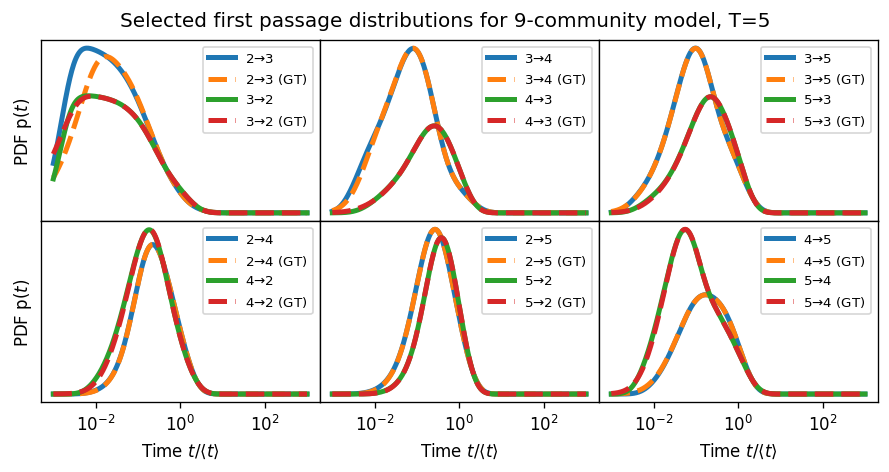

In [4]:
fig,axs = plt.subplots(2,3,figsize=(9,4),dpi=120,sharex='col')
fig.patch.set_facecolor('white')
cc = 0
pbar = tqdm(total=6)
for cA in range(2,6):
    for cB in range(2,6):
        if cA>cB:
            A_sel = communities==cA-1
            B_sel = communities==cB-1

            # define initial distribution as in paper
            p_0 = np.zeros(pi.shape)
            p_0[A_sel] = np.arange(A_sel.sum()) == pi[A_sel].argmax()
            p_0[B_sel] = np.arange(B_sel.sum()) == pi[B_sel].argmax()

            # define same quantities for GT reduced system
            r_p_0 = p_0[retained_states]
            r_A_sel = A_sel[retained_states]
            r_B_sel = B_sel[retained_states]

            # mfpt: <t_AB>, <t^2_AB>, <t_BA>, <t^2_BA>
            mfpt,fptd = fpt(A_sel=A_sel,B_sel=B_sel,pi=p_0,K=Q,dopdf=True)


            # r_mfpt: <t_AB>, <t^2_AB>, <t_BA>, <t^2_BA>
            r_mfpt,r_fptd = \
                fpt(A_sel=r_A_sel,B_sel=r_B_sel,pi=r_p_0,K=r_Q,dopdf=True)

            i,j = cc%2,cc//2
            axs[i,j].semilogx(fptd[:,2]/mfpt[2],fptd[:,3],lw=3,
                            label=fr"{cB}$\to${cA}")
            axs[i,j].semilogx(r_fptd[:,2]/mfpt[2],r_fptd[:,3],'--',lw=3,
                            label=fr"{cB}$\to${cA} (GT)")

            axs[i,j].semilogx(fptd[:,0]/mfpt[0],fptd[:,1],lw=3,
                            label=fr"{cA}$\to${cB}")
            axs[i,j].semilogx(r_fptd[:,0]/mfpt[0],r_fptd[:,1],'--',lw=3,
                            label=fr"{cA}$\to${cB} (GT)")

            axs[i,j].set_yticks([])
            if i==0:
                axs[i,j].set_xticks([])
            else:
                axs[i,j].set_xlabel(r"Time $t/\langle{t}\rangle$")

            if j==0:
                axs[i,j].set_ylabel(r"PDF ${\rm p}(t)$")

            axs[i,j].legend(fontsize=8)
            cc+=1
            pbar.update(1)
plt.suptitle("Selected first passage distributions for 9-community model,"
  f" T={int(T)}",y=0.94)
plt.subplots_adjust(wspace=0,hspace=0)
plt.savefig(f"pdf_comp_T{int(T)}.pdf")
plt.show()